### Data Modeling and Evaluation

In [1]:
# Required package.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

%matplotlib inline

RANDOM_SEED = 19730115
rng = np.random.RandomState(RANDOM_SEED)


print("Required packages installed.")

Required packages installed.


In [2]:
def load_pickle_dataset(path):
    """Read pickle.

    Args:
        path (str): The full dataset file.

    Returns:
        dataframe: A pandas dataframe.
    """

    # Get the features and target variable.
    data = pd.read_pickle(path)
    features, target = data.iloc[:, 1:-1].values, data.iloc[:, -1].values

    return features, target


In [3]:

def train_model(X_train, y_train, estimator=None, distributions=None):
    """Split the dataframe in training and testing partitions.
    """
    
    kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=rng)

    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=distributions,
        scoring='f1_micro',
        refit=True,
        verbose=0,
        random_state=rng
    )

    model = search.fit(X_train, y_train)
    return model.best_estimator_, model.cv_results_['mean_test_score']


def test_model(model, X_test, y_test):
    """Test model.
    """
    y_pred = model.predict(X_test)
    return f1_score(y_pred, y_test, average='micro')


In [4]:
reviews_train_features_cv, reviews_train_target_cv = load_pickle_dataset('../data/processed/buscape_reviews_train_dataset_cv.pkl')
print(reviews_train_features_cv.shape)
reviews_test_features_cv, reviews_test_target_cv = load_pickle_dataset('../data/processed/buscape_reviews_test_dataset_cv.pkl')
print(reviews_test_features_cv.shape)

reviews_train_features_tv, reviews_train_target_tv = load_pickle_dataset('../data/processed/buscape_reviews_train_dataset_tv.pkl')
print(reviews_train_features_tv.shape)
reviews_test_features_tv, reviews_test_target_tv = load_pickle_dataset('../data/processed/buscape_reviews_test_dataset_tv.pkl')
print(reviews_test_features_tv.shape)

reviews_train_features_gv, reviews_train_target_gv = load_pickle_dataset('../data/processed/buscape_reviews_train_dataset_gv.pkl')
print(reviews_train_features_gv.shape)
reviews_test_features_gv, reviews_test_target_gv = load_pickle_dataset('../data/processed/buscape_reviews_test_dataset_gv.pkl')
print(reviews_test_features_gv.shape)

(27196, 100)
(6799, 100)
(27196, 100)
(6799, 100)
(27196, 51)
(6799, 51)


In [5]:
train_scores, test_scores = [], []
baseline_estimator = KNeighborsClassifier()
baseline_estimator_distributions = {
        'n_neighbors': list(range(1, 31, 2)), 
        'weights': ['uniform', 'distance']
}

In [6]:
model, scores = train_model(reviews_train_features_cv, reviews_train_target_cv, baseline_estimator, baseline_estimator_distributions)
train_scores.append(list(scores))

test_scores.append(test_model(model, reviews_test_features_cv, reviews_test_target_cv))

In [7]:
model, scores = train_model(reviews_train_features_tv, reviews_train_target_tv, baseline_estimator, baseline_estimator_distributions)
train_scores.append(list(scores))

test_scores.append(test_model(model, reviews_test_features_tv, reviews_test_target_tv))

In [8]:

model, scores = train_model(reviews_train_features_gv, reviews_train_target_gv, baseline_estimator, baseline_estimator_distributions)
train_scores.append(list(scores))

test_scores.append(test_model(model, reviews_test_features_gv, reviews_test_target_gv))

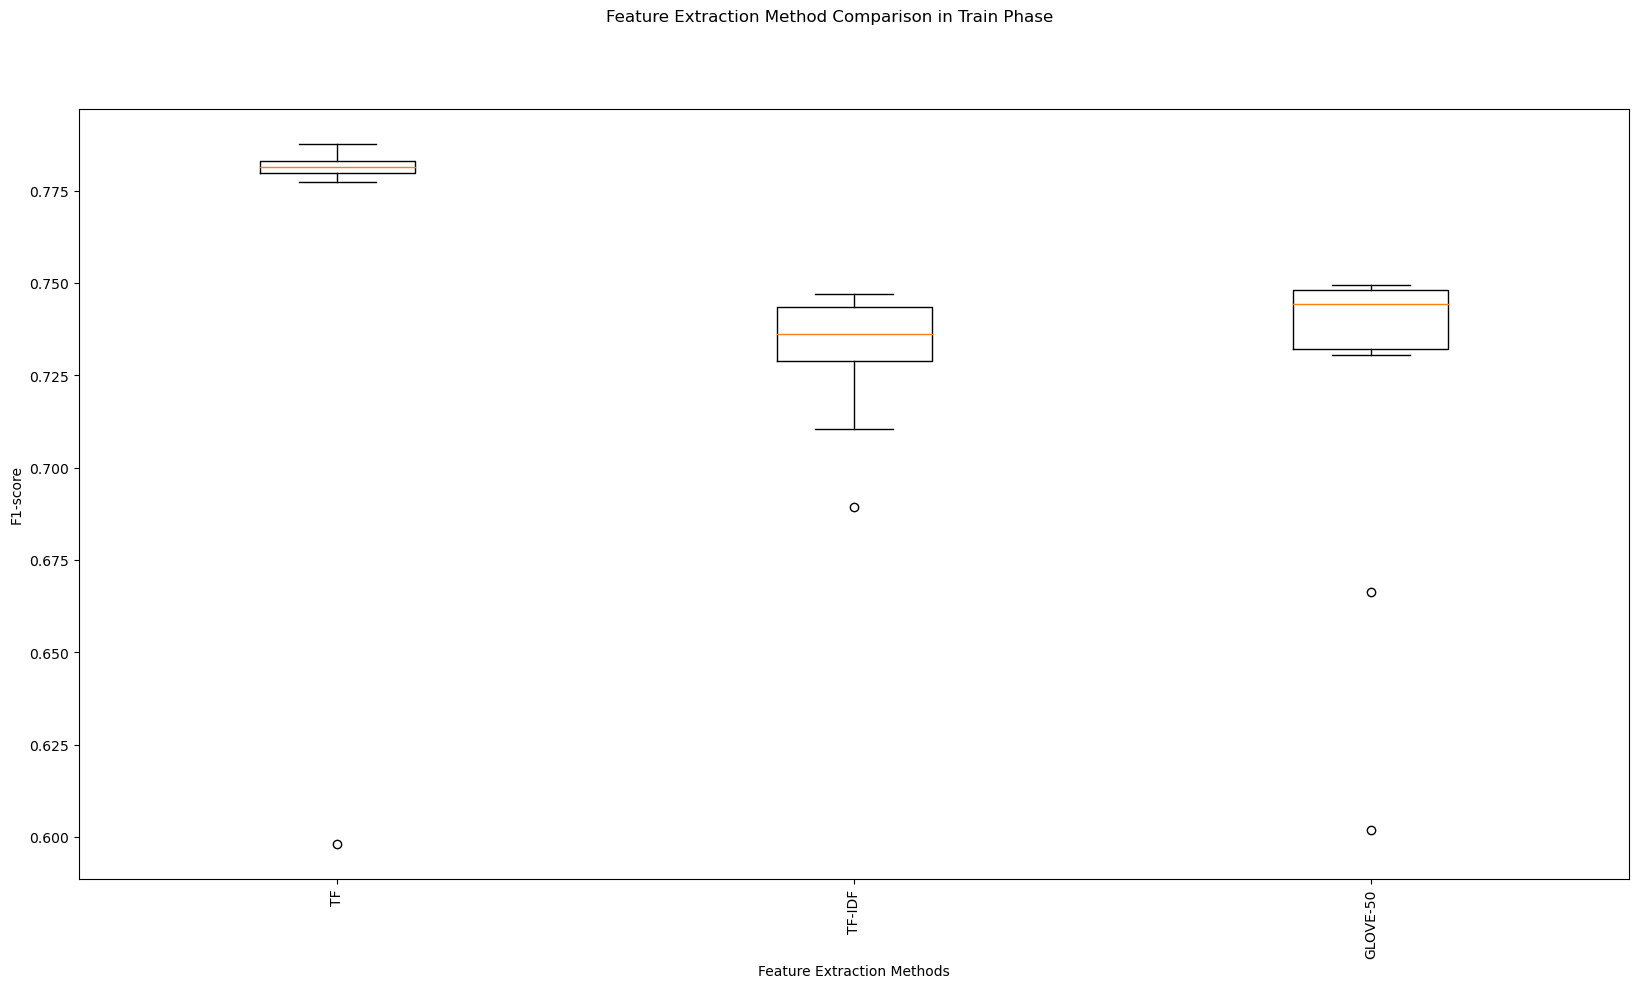

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=90)
fig.suptitle('Feature Extraction Method Comparison in Train Phase')
_ = plt.boxplot(train_scores)
ax.set_xticklabels(['TF', 'TF-IDF', 'GLOVE-50'])
ax.set_ylabel('F1-score')
ax.set_xlabel('Feature Extraction Methods')
plt.show()

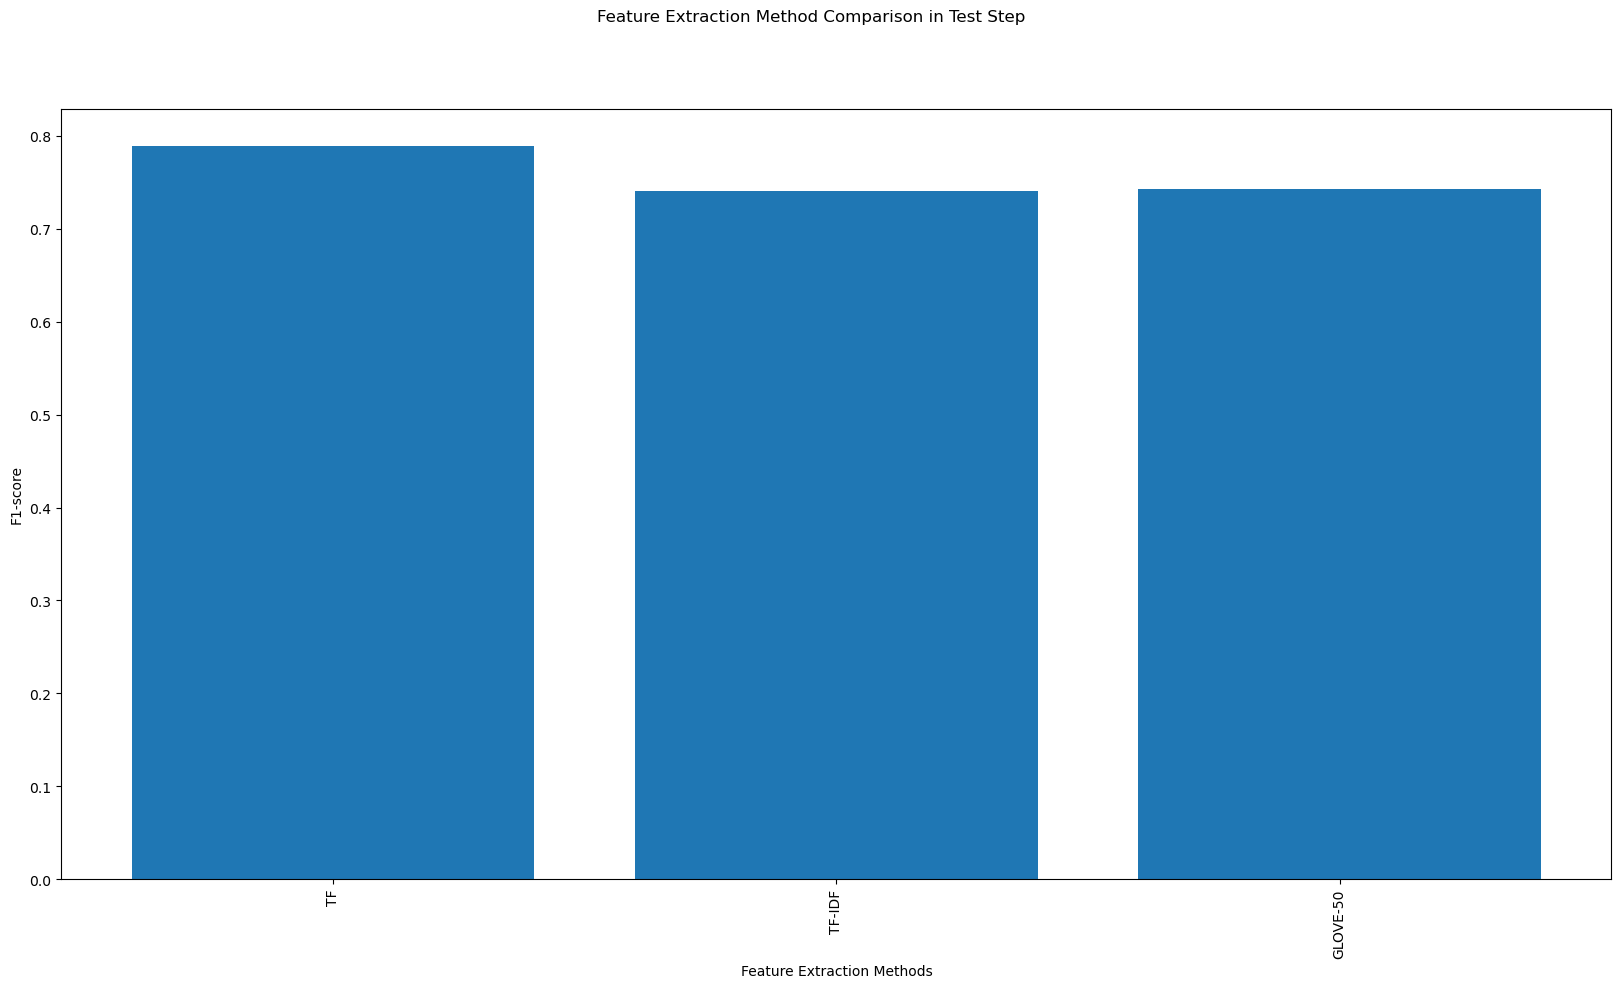

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=90)
fig.suptitle('Feature Extraction Method Comparison in Test Step')
_ = plt.bar(['TF', 'TF-IDF', 'GLOVE-50'], test_scores)
ax.set_ylabel('F1-score')
ax.set_xlabel('Feature Extraction Methods')
plt.show()